# Statoil-C-CORE-Iceberg-Classifier-Challenge - CNN with inception and ensembling

<a name="toc"/>
## TOC

[1. Introduction](#introduction)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[1.1 Intro](#introduction-intro)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[1.2 Imports](#introduction-imports)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[1.3 Setup](#introduction-setup)<br>
<br>
[2. Data](#data)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.1 Load training data](#data-loading)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.2 Imputing missing values](#data-missing-values)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.3 Transform data for NN](#data-transform-for-nn)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.4 EDA](#data-eda)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.4.1 Data visualisation](#data-visualisation)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.5 Training, validation, holdout splits](#data-split)<br>
<br>
[3. Usefull functions](#functions)<br>
<br>
[4. Data Augmentation](#data-augmentation)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[4.1 Adding noise](#aug-noise)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[4.2 Data generator with image augmentation](#aug-datagen)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[4.3 Add more augmented validation data](#aug-gen-val-data)<br>
<br>

&nbsp;&nbsp;&nbsp;&nbsp;[NN denosing](#nn-denoising)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[CNN model](#cnn-model)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[Model reset](#model-reset)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[Callbacks](#training-callbacks)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[Model training](#model-training)<br>

<a name="introduction"/>
## 1. Introduction

<a name="introduction-intro"/>
### 1.1 Intro

[>> back to TOC <<](#toc)

<a name="introduction-imports"/>
### 1.2 Imports

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
import math
import pickle
import datetime
import heapq
import xgboost as xgb
import h5py
from tqdm import tqdm_notebook as tqdm

from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Reshape, Lambda, ZeroPadding2D, GaussianNoise, AlphaDropout, Input, Concatenate
from keras.layers.core import Flatten, Dropout
from keras.optimizers import Adam, SGD
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical, normalize
from keras.models import model_from_json
from keras_tqdm import TQDMNotebookCallback, TQDMCallback

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import tensorflow as tf

from scipy import ndimage
from skimage.morphology import reconstruction
from skimage.restoration import denoise_wavelet, denoise_tv_chambolle, denoise_nl_means

from cyclicLR_callback import CyclicLR

random_seed = 4321
np.random.seed(random_seed)
cwd = os.getcwd()
#for windows
model_path = cwd + '\\models\\'

/home/marozet2/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
import keras
keras.__version__

'2.1.3'

In [3]:
import cv2
cv2.__version__

'3.3.1'

[>> back to TOC <<](#toc)

<a name="introduction-setup"/>
### 1.3 Setup

Manually create tensorflow session to avoid potential OEM errors on laptop's GPU.

In [4]:
tf.set_random_seed(random_seed)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.set_session(session)
K.set_image_dim_ordering('tf')

In [5]:
!nvidia-smi

/bin/sh: 1: nvidia-smi: not found


[>> back to TOC <<](#toc)

<a name="data"/>
## 2. Data

<a name="data-loading"/>
### 2.1 Load training data

In [6]:
data = pd.read_json("data/processed/train.json", orient='records')
data.head()
train_df = data

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1604 entries, 0 to 1603
Data columns (total 5 columns):
band_1        1604 non-null object
band_2        1604 non-null object
id            1604 non-null object
inc_angle     1604 non-null object
is_iceberg    1604 non-null int64
dtypes: int64(1), object(4)
memory usage: 75.2+ KB


[>> back to TOC <<](#toc)

<a name="data-missing-values"/>
### 2.2 Missing values

In [8]:
train_df['inc_angle_f'] = pd.to_numeric(train_df['inc_angle'], errors='coerce')
print("missing values in inc_angle: ", train_df['inc_angle_f'].isnull().sum())
#train_df['inc_angle_f'].replace(np.nan,train_df['inc_angle_f'].mean(), inplace=True)
train_df['inc_angle_f'].replace(np.nan,0, inplace=True)
train_df.tail()

missing values in inc_angle:  133


,band_1,band_2,id,inc_angle,is_iceberg,inc_angle_f
1599,"[-30.999878, -29.976866, -28.233906, -29.50732...","[-27.847719, -28.233864, -24.712077999999998, ...",04e11240,na,0,0.0
1600,"[-25.31155, -26.511555, -28.694487, -27.180115...","[-29.563713, -28.290375, -26.839405, -28.29046...",c7d6f6f8,na,0,0.0
1601,"[-18.141895, -18.141844, -19.01737, -19.701599...","[-25.305355, -29.387701, -28.963863, -26.16023...",bba1a0f1,na,0,0.0
1602,"[-22.455633, -25.794661, -26.954567, -22.83354...","[-26.070356, -22.093737, -21.577662, -24.53376...",7f66bb44,na,0,0.0
1603,"[-19.909191, -20.678406, -20.208834, -18.42441...","[-24.44487, -24.956001, -27.722103, -26.078417...",9d8f326c,na,0,0.0


[>> back to TOC <<](#toc)

<a name="data-transform-for-nn"/>
### 2.3 Transform data for NN

In [9]:
def get_bands(train_df):
    #set max value to 10 in all bands
    max_col = np.array(train_df.apply(lambda x: max((max(train_df.loc[x.name,'band_1']),max(train_df.loc[x.name,'band_2']))),axis=1)) - 10
    max_col2 = max_col.reshape(-1,1) * np.ones(75*75).reshape(1,75*75)
    max_col2 = max_col2.reshape(-1,75,75)

    band_1 = np.array(train_df['band_1'].tolist()).reshape(-1,75,75) - max_col2
    band_2 = np.array(train_df['band_2'].tolist()).reshape(-1,75,75) - max_col2
    band_1_t = 10**(band_1/10)
    band_2_t = 10**(band_2/10)
    band_1_t = np.where(band_1_t > 0.01, band_1_t, 0)
    band_2_t = np.where(band_2_t > 0.01, band_2_t, 0)
    band_3 = band_1_t - band_2_t
    X = np.stack((band_1,band_2,band_1_t,band_2_t),axis=3)
    
    return band_1, band_2, band_1_t, band_2_t, band_3, X

In [10]:
band_1, band_2, band_1_t, band_2_t, band_3, X = get_bands(train_df)

In [11]:
y = train_df.loc[:,'is_iceberg']
y_angle = train_df.loc[:,['is_iceberg','inc_angle_f']]
y_angle['index'] = y_angle.index

In [12]:
y_angle.head()

,is_iceberg,inc_angle_f,index
0,0,43.9239,0
1,0,38.1562,1
2,1,45.2859,2
3,0,43.8306,3
4,0,35.6256,4


[>> back to TOC <<](#toc)

<a name="data-eda"/>
### 2.4 EDA

<a name="data-visualisation"/>
#### 2.4.1 Data visualisation

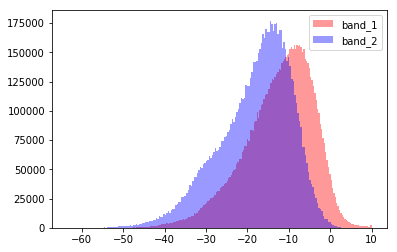

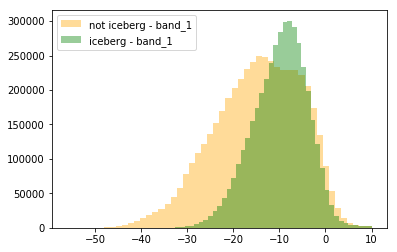

In [13]:
plt.hist(band_1.flatten(), bins=200, color="red", alpha=0.4, label='band_1')
plt.hist(band_2.flatten(), bins=200, color="blue", alpha=0.4, label='band_2')
plt.legend()
plt.show()

plt.hist(band_1[train_df[train_df['is_iceberg']==0].index].flatten(), bins=50, color="orange", alpha=0.4, 
         label='not iceberg - band_1')
plt.hist(band_1[train_df[train_df['is_iceberg']==1].index].flatten(), bins=50, color="green", alpha=0.4,
         label='iceberg - band_1')
plt.legend()
plt.show()

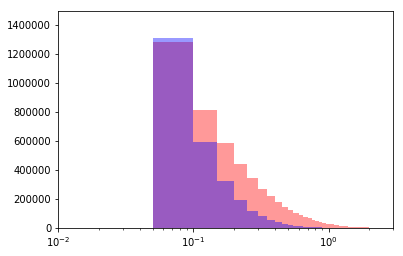

In [14]:
plt.hist(band_1_t.flatten(),bins=200, color="red", alpha=0.4)
plt.hist(band_2_t.flatten(),bins=200, color="blue", alpha=0.4)
#plt.yscale('log')
plt.xscale('log')
plt.xlim([1e-2,3])
plt.ylim([1e-5,1500000])
plt.show()

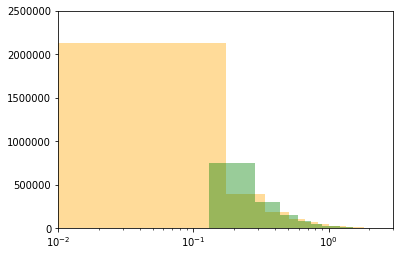

In [15]:
plt.hist(band_3[train_df[train_df['is_iceberg']==0].index].flatten(), bins=100, color="orange", alpha=0.4)
plt.hist(band_3[train_df[train_df['is_iceberg']==1].index].flatten(), bins=100, color="green", alpha=0.4)
#plt.yscale('log')
plt.xscale('log')
plt.xlim([1e-2,3])
plt.ylim([1e-5,2500000])
plt.show()

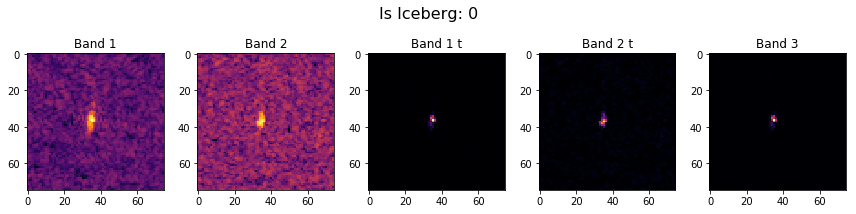

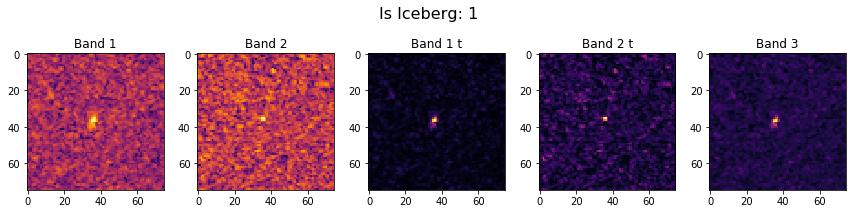

In [16]:
def plot_bands(index, cmap="gray"):
    fig = plt.figure(figsize=(12,6))
    fig.suptitle("Is Iceberg: %x" % (train_df.loc[index,'is_iceberg']), fontsize=16)
    ax1 = fig.add_subplot(251)
    ax1.set_title("Band 1")
    ax1.imshow(band_1[index], cmap=cmap)
    ax2 = fig.add_subplot(252)
    ax2.set_title("Band 2")
    ax2.imshow(band_2[index], cmap=cmap)
    ax3 = fig.add_subplot(253)
    ax3.set_title("Band 1 t")
    ax3.imshow(band_1_t[index], cmap=cmap)
    ax3 = fig.add_subplot(254)
    ax3.set_title("Band 2 t")
    ax3.imshow(band_2_t[index], cmap=cmap)
    ax3 = fig.add_subplot(255)
    ax3.set_title("Band 3")
    ax3.imshow(band_3[index], cmap=cmap)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_bands(0,cmap="inferno")
plot_bands(2,cmap="inferno")


[>> back to TOC <<](#toc)

<a name="data-split"/>
### 2.5 Training, validation, holdout split

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y_angle, test_size=0.35, random_state=random_seed)
print(X_train.shape)
print(X_val.shape)

(1042, 75, 75, 4)
(562, 75, 75, 4)


In [18]:
X_val_tune, X_val_test, y_val_tune, y_val_test = train_test_split(X_val, y_val, test_size=0.3, random_state=random_seed)
print(X_val_tune.shape)
print(X_val_test.shape)

(393, 75, 75, 4)
(169, 75, 75, 4)


[>> back to TOC <<](#toc)

<a name="functions"/>
## 3. Usefull functions

In [19]:
def apply_over_axis(func, data, mask=None, axis=0, *args, **kwargs):
    f_list = []
    for i in range(data.shape[axis]):
        if mask is None:
            f_list.append(func(data[i], *args, **kwargs))
        else:
            f_list.append(func(data[i], mask=mask[i], *args, **kwargs))
    return np.stack(f_list,axis=0)

In [20]:
def plot_imgs(imgs, y, cmap="inferno"):
    for idx in range(imgs.shape[0]):
        fig = plt.figure(figsize=(12,6))
        fig.suptitle("Is Iceberg: %x" % int(y.iloc[idx]['is_iceberg']), fontsize=16)
        ax1 = fig.add_subplot(251)
        ax1.set_title("Band 1")
        ax1.imshow(imgs[idx,:,:,0], cmap=cmap)
        ax2 = fig.add_subplot(252)
        ax2.set_title("Band 2")
        ax2.imshow(imgs[idx,:,:,1], cmap=cmap)
        ax3 = fig.add_subplot(253)
        ax3.set_title("Band 1 t")
        ax3.imshow(imgs[idx,:,:,2], cmap=cmap)
        ax4 = fig.add_subplot(254)
        ax4.set_title("Band 2 t")
        ax4.imshow(imgs[idx,:,:,3], cmap=cmap)
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

[>> back to TOC <<](#toc)

<a name="data-augmentation"/>
## 4. Data augmentation

<a name="aug-noise"/>
### 5.1 Adding noise

In [21]:
def add_noise(img, noise):
    rand_img = np.zeros(img.shape)
    cv2.randn(rand_img,noise[0],noise[1]) 
    return img + rand_img

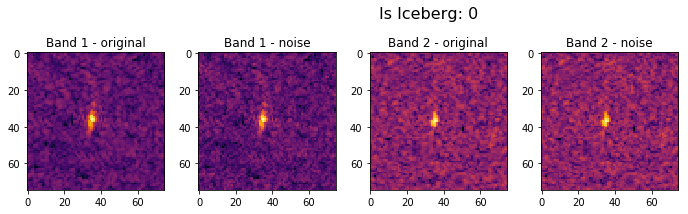

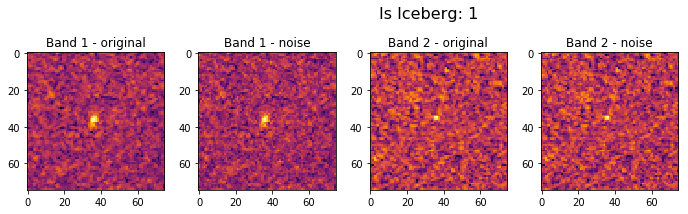

In [22]:
def plot_with_noise(index, cmap="gray"):
    m = (1) 
    s = (1)
    fig = plt.figure(figsize=(12,6))
    fig.suptitle("Is Iceberg: %x" % (train_df.loc[index,'is_iceberg']), fontsize=16)
    ax1 = fig.add_subplot(251)
    ax1.set_title("Band 1 - original")
    ax1.imshow(band_1[index], cmap=cmap)
    ax2 = fig.add_subplot(252)
    ax2.set_title("Band 1 - noise")
    img = band_1[index].copy()
    rand_img = np.zeros((img.shape[0],img.shape[1]))
    cv2.randn(rand_img,m,s);
    img = img + rand_img
    ax2.imshow(img, cmap=cmap)
    ax3 = fig.add_subplot(253)
    ax3.set_title("Band 2 - original")
    ax3.imshow(band_2[index], cmap=cmap)
    ax4 = fig.add_subplot(254)
    ax4.set_title("Band 2 - noise")
    img = band_2[index].copy()
    rand_img = np.zeros((img.shape[0],img.shape[1]))
    m = (0.5) 
    s = (0.5)
    cv2.randn(rand_img,m,s);
    img = img + rand_img
    ax4.imshow(img, cmap=cmap)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_with_noise(0,cmap="inferno")
plot_with_noise(2,cmap="inferno")

In [23]:
#set noise params
aug_noise=((0,0,0,0),(0.25,0.25,0.05,0.05))

[>> back to TOC <<](#toc)

<a name="aug-datagen"/>
### 4.2 Data generators with image augmentation

In [24]:
X_train_sample = X_train[:]
y_train_sample = y_train[:]
print(X_train_sample.shape)

(1042, 75, 75, 4)


In [25]:


datagen = ImageDataGenerator(
    samplewise_center=False,
    samplewise_std_normalization=False,
    rotation_range=179,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

datagen_val = ImageDataGenerator(
    samplewise_center=False,
    samplewise_std_normalization=False,
    rotation_range=0,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest')

#custom generator for fit_generator
from collections import Generator
class Datagen_angle(Generator):
    def __init__(self, imagegen=ImageDataGenerator, noise=((1,1),(1,1))):
        self.imagegen = imagegen
        self.noise = noise
        self.noise_on = False
        
    def flow(self, x, y, batch_size=8, shuffle=True, noise_on = False, noise=((1,1),(1,1))):
        self.generator = self.imagegen.flow(x, y, batch_size=batch_size, shuffle=shuffle)
        self.noise_on = noise_on
        self.noise=noise
        return self
    
    def send(self, ignored):
        temp_data = next(self.generator)
        if self.noise_on:
            batches = temp_data[0][:,:,:,:4].copy()
            batches = apply_over_axis(add_noise, batches, axis=0, noise=self.noise)
            temp_stacked1 = batches[:,:,:,:2]
            temp_band_3 = batches[:,:,:,2] - batches[:,:,:,3] #band_1_t - band_2_t
            temp_stacked2 = np.stack((batches[:,:,:,2],batches[:,:,:,3],temp_band_3),axis=3)
        else:
            #temp_stacked1 = np.stack((temp_data[0][:,:,:,0],temp_data[0][:,:,:,1]),axis=3)
            temp_stacked1 = temp_data[0][:,:,:,:2]
            temp_band_3 = temp_data[0][:,:,:,2] - temp_data[0][:,:,:,3] #band_1_t - band_2_t
            temp_stacked2 = np.stack((temp_data[0][:,:,:,2],temp_data[0][:,:,:,3],temp_band_3),axis=3)
        #nn_denoised_temp = temp_data[0] #pass 4 bands for nn denoising input
        return [temp_stacked1, temp_stacked2, 
                #nn_denoised_temp,
                temp_data[1][:,1]], temp_data[1][:,0]
    
    def get_next(self):
        temp_data = next(self.generator)
        if self.noise_on:
            batches = temp_data[0][:,:,:,:4].copy()
            batches = apply_over_axis(add_noise, batches, axis=0, noise=self.noise)
        else:
            batches = temp_data[0]
        return batches, temp_data[1]
    
    def throw(self, type=None, value=None, traceback=None):
        raise StopIteration
    



In [26]:

datagen.fit(X_train_sample)
datagen_val.fit(X_val)

datagen_angle = Datagen_angle(imagegen=datagen)
datagen_angle_val = Datagen_angle(imagegen=datagen_val)

[>> back to TOC <<](#toc)

<a name="aug-gen-val-data"/>
### 4.3 Add more augmented validation data

In [27]:
X_val_tune.shape

(393, 75, 75, 4)

In [28]:
y_val_tune.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393 entries, 52 to 687
Data columns (total 3 columns):
is_iceberg     393 non-null int64
inc_angle_f    393 non-null float64
index          393 non-null int64
dtypes: float64(1), int64(2)
memory usage: 12.3 KB


In [29]:
def get_augmented(gen):
    x_new, y_new = gen.get_next()
    y_new_df = pd.DataFrame(y_new, columns=y_val_tune.columns)
    y_new_df['is_iceberg'] = y_new_df['is_iceberg'].astype(np.int)
    y_new_df['index'] = y_new_df['index'].astype(np.int)
    y_new_df.index = y_new_df['index']
    return x_new, y_new_df

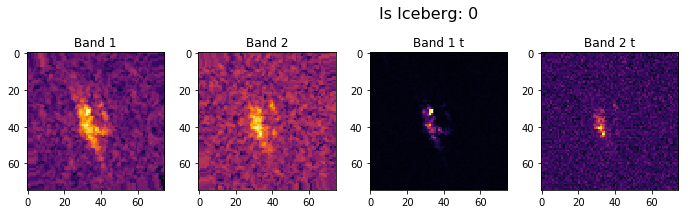

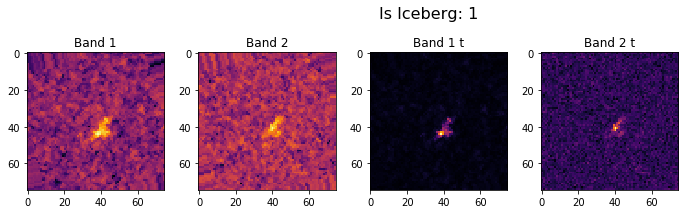

In [30]:
validation_generator = datagen_angle.flow(X_val_tune, y_val_tune, batch_size=8, 
                                          noise_on=True, noise=aug_noise)
x_new, y_new_df = get_augmented(validation_generator)
plot_imgs(x_new[:2], y_new_df.iloc[:2])

In [31]:
validation_generator = datagen_angle.flow(X_val_tune, y_val_tune, batch_size=256, 
                                          noise_on=False, noise=aug_noise)
X_val_tune2 = X_val_tune
y_val_tune2 = y_val_tune
for _ in tqdm(range(5)):
    x_new, y_new_df = get_augmented(validation_generator)
    X_val_tune2 = np.append(X_val_tune2, x_new, axis=0)
    y_val_tune2 = pd.concat([y_val_tune2, y_new_df])
X_val_tune2.shape

A Jupyter Widget

(1435, 75, 75, 4)

In [32]:
validation_generator = datagen_angle.flow(X_val_test, y_val_test, batch_size=256, 
                                          noise_on=False, noise=aug_noise)
X_val_test2 = X_val_test
y_val_test2 = y_val_test
for _ in tqdm(range(5)):
    x_new, y_new_df = get_augmented(validation_generator)
    X_val_test2 = np.append(X_val_test2, x_new, axis=0)
    y_val_test2 = pd.concat([y_val_test2, y_new_df])
X_val_test2.shape

A Jupyter Widget

(1014, 75, 75, 4)

[>> back to TOC <<](#toc)

<a name="nn-denoising"/>
### NN denoising

In [33]:
##custom generator for denoising
#from collections import Generator
#class Datagen_denoising(Generator):
#    def __init__(self, imagegen=ImageDataGenerator):
#        self.imagegen = imagegen
#        
#    def flow(self, x, y, batch_size=8, shuffle=True):
#        self.generator = self.imagegen.flow(x, y, batch_size=batch_size, shuffle=shuffle)
#        return self
#    
#    def send(self, ignored):
#        temp_data = next(self.generator)
#        temp_stacked1 = np.stack((temp_data[0][:,:,:,0],temp_data[0][:,:,:,1]),axis=3)
#        temp_stacked = np.stack((temp_data[0][:,:,:,0],temp_data[0][:,:,:,1],temp_data[0][:,:,:,2],
#                                temp_data[0][:,:,:,3]),axis=3)
#        return temp_stacked, temp_stacked
#    
#    def throw(self, type=None, value=None, traceback=None):
#        raise StopIteration
#        
#datagen_denoising = Datagen_denoising(imagegen=datagen)
#datagen_denoising_val = Datagen_denoising(imagegen=datagen_val)

In [34]:
#m_input = Input(shape=(75,75,4), name='m_input')
#
##conv layers for main_input
#x1 = BatchNormalization()(m_input)
#x1 = ZeroPadding2D()(x1)
#x1 = Conv2D(8, (3,3), activation='relu')(x1)
#x1 = BatchNormalization()(x1)
#x1 = Dropout(0.2)(x1)
#x1 = ZeroPadding2D()(x1)
#x1 = Conv2D(8, (3,3), activation='relu')(x1)
#x1 = BatchNormalization()(x1)
#x1 = Dropout(0.2)(x1)
#x1 = ZeroPadding2D()(x1)
#m_output = Conv2D(4, (3,3), activation='linear', name='m_output')(x1)
#model_denoise = Model(inputs=[m_input,], outputs=[m_output], name='Model_nn_denoising')
#
#model_denoise.compile(optimizer=Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0),
#loss='mean_squared_error',
#metrics=['mae'])

In [35]:
#model_denoise.summary()

In [36]:
##model training
##lScheduler_denoising = LScheduler(initial_lrate=0.1, drop=0.66, patience=3)
##lrScheduler_denoising = LearningRateScheduler(lScheduler_denoising.step_decay)
#lrScheduler_denoising = CyclicLR(base_lr=1e-8, max_lr=0.006,
#                                 step_size=400, mode='triangular2', gamma=0.99994)
#start_time = time.monotonic()
#
#H = model_denoise.fit_generator(datagen_denoising.flow(X, y_angle, batch_size=8),
#                    steps_per_epoch=len(X)/8,
#                    validation_data=datagen_denoising_val.flow(X, y_angle, batch_size=8, shuffle=False), 
#                    validation_steps=len(X)/8,
#                    #validation_data=[X_val,y_val],
#                    epochs=12,
#                    callbacks = [lrScheduler_denoising, 
#                                 TQDMNotebookCallback(leave_inner=True, leave_outer=True)],
#                    verbose=0)
#
#model_time = time.monotonic() - start_time
#print("Model training time: " + '{:d}'.format(int(model_time // 60)) + " minutes " 
#      + '{:.1f}'.format(model_time % 60) + " seconds")

In [37]:
#h = lrScheduler_denoising.history
#plt.plot(h['lr'], color="b", label='lr')
#plt.legend()
#plt.xlabel('# iterations')
#plt.show()

In [38]:
## serialize model to JSON
#model_json = model_denoise.to_json()
#with open("models/model_denoise.json", "w") as json_file:
#    json_file.write(model_json)

In [39]:
## serialize weights to HDF5
#model_weights = model_denoise.get_weights()
#with open('models/model_denoise_weights.pickle', 'wb') as handle:
#    pickle.dump(model_weights, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [40]:
## load json and create model
#with open("models/model_denoise.json", "r") as json_file:
#    loaded_model_json = json_file.read()
#model_denoise = model_from_json(loaded_model_json)
## load weights into new model
#with open('models/model_denoise_weights.pickle', 'rb') as handle:
#    model_weights = pickle.load(handle)
#model_denoise.set_weights(model_weights)
#print("Loaded model from disk")

In [41]:
#X_nn_denoised = model_denoise.predict(X, verbose=1)

In [42]:
#index=8
#original_index = y_train_sample.iloc[index].name
#cmap="inferno"
#fig = plt.figure(figsize=(12,6))
#fig.suptitle("Image denoising nn: %x" % (train_df.loc[original_index,'is_iceberg']), fontsize=16)
#ax1 = fig.add_subplot(251)
#ax1.set_title("Before band_1")
#ax1.imshow(X_train_sample[index][:,:,0], cmap=cmap)
#ax2 = fig.add_subplot(252)
#ax2.set_title("NN Denoising band 1")
#ax2.imshow(X_nn_denoised[original_index][:,:,0], cmap=cmap)
#ax3 = fig.add_subplot(253)
#ax3.set_title("Before band 2")
#ax3.imshow(X_train_sample[index][:,:,1], cmap=cmap)
#ax4 = fig.add_subplot(254)
#ax4.set_title("NN Denoising band 2")
#ax4.imshow(X_nn_denoised[original_index][:,:,1], cmap=cmap)
#plt.show()

[>> back to TOC <<](#toc)

<a name="cnn-model"/>
### CNN model

In [43]:
model_code="CNN_2018_01_24_v03"
model_comment="2 CNN inputs + simplified inception block + noise augmentation, na=0"

In [44]:
%%writefile current_model.py

def SimpleInceptionBlock(x, filters=64, dropout=0.2, prefix=''):
    #path 1
    x1 = Conv2D(filters, (1,1), padding='same', activation='relu', name=prefix + '11_Conv_1_1')(x)
    x1 = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name=prefix + '12_MaxPool_2_2')(x1)
    x1 = BatchNormalization()(x1)
    x1 = Dropout(dropout)(x1) 
    #path 2
    x2 = Conv2D(filters, (3,3), activation='relu', padding='same', name=prefix + '21_Conv_3_3')(x)
    x2 = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name=prefix + '22_MaxPool_2_2')(x2)
    x2 = BatchNormalization()(x2)
    x2 = Dropout(dropout)(x2) 
    #path 3
    x3 = Conv2D(filters, (1,1), activation='relu', padding='same', name=prefix + '31_Conv_1_1')(x)
    x3 = Conv2D(filters, (5,5), activation='relu', padding='same', name=prefix + '32_Conv_5_5')(x3)
    x3 = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name=prefix + '33_MaxPool_2_2')(x3)
    x3 = BatchNormalization()(x3)
    x3 = Dropout(dropout)(x3)
    #concatenate
    x = Concatenate(axis=3, name=prefix+'_Inception_end')([x1,x2,x3])
    return x

def ConvBlock(x, filters=64, dropout=0.2, prefix=''):
    x = Conv2D(filters, (3,3), activation='relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x) 
    
def InputBlock(x, dropout=0.2, prefix=''):
    #conv layers for input
    x = BatchNormalization()(x)
    x = SimpleInceptionBlock(x, prefix=prefix+'_1_')
    x = SimpleInceptionBlock(x, prefix=prefix+'_2_')
    #x = ConvBlock(x)
    #x = ConvBlock(x)
    return(x)

main_input = Input(shape=(75,75,2), name='main_input')
aux_input = Input(shape=(75,75,3), name='aux_input')
    #aux_input_nn = Input(shape=(75,75,4), name='aux_input_nn')

x1 = InputBlock(main_input, prefix='m_input')
x2 = InputBlock(aux_input, prefix='a_input')
    #x3 = model_denoise(aux_input_nn)
    #x3 = InputBlock(x3,dropout=0.3, prefix='a_input_nn')

    #x = x1
x = Concatenate(axis=3)([x1,x2])
    #x = BatchNormalization()(x)
    #x = Dropout(0.2)(x)

    #conv-blocks
#x = ConvBlock(x, filters=128)
#x = ConvBlock(x, filters=256)

    #inception blocks
x = SimpleInceptionBlock(x, filters=128, prefix='main_1')
x = SimpleInceptionBlock(x, filters=256, prefix='main_2')

    #flatten
x = Flatten()(x)
angle_input = Input(shape=[1], name='angle_input')
    #x1 = BatchNormalization()(angle_input)
merged = Concatenate()([x, angle_input])
    
    #dense-block
x = Dense(1025, activation='relu')(merged)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
    
    #dense-block
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
    
main_output = Dense(1, activation='sigmoid', name='main_output')(x)
model_f = Model(inputs=[main_input,aux_input, 
                            #aux_input_nn, 
                            angle_input], 
                            outputs=[main_output])

model_f.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0),
    loss='binary_crossentropy',
    metrics=['accuracy'])
    

Overwriting current_model.py


<a name="model-reset"/>
#### Model reset

In [45]:
%run -i current_model.py

[>> back to TOC <<](#toc)

In [46]:
#model_f = build_model()

In [47]:
model_f.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 75, 75, 2)    0                                            
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 75, 75, 2)    8           main_input[0][0]                 
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 75, 75, 3)    12          aux_input[0][0]                  
__________________________________________________________________________________________________
m_input_1_

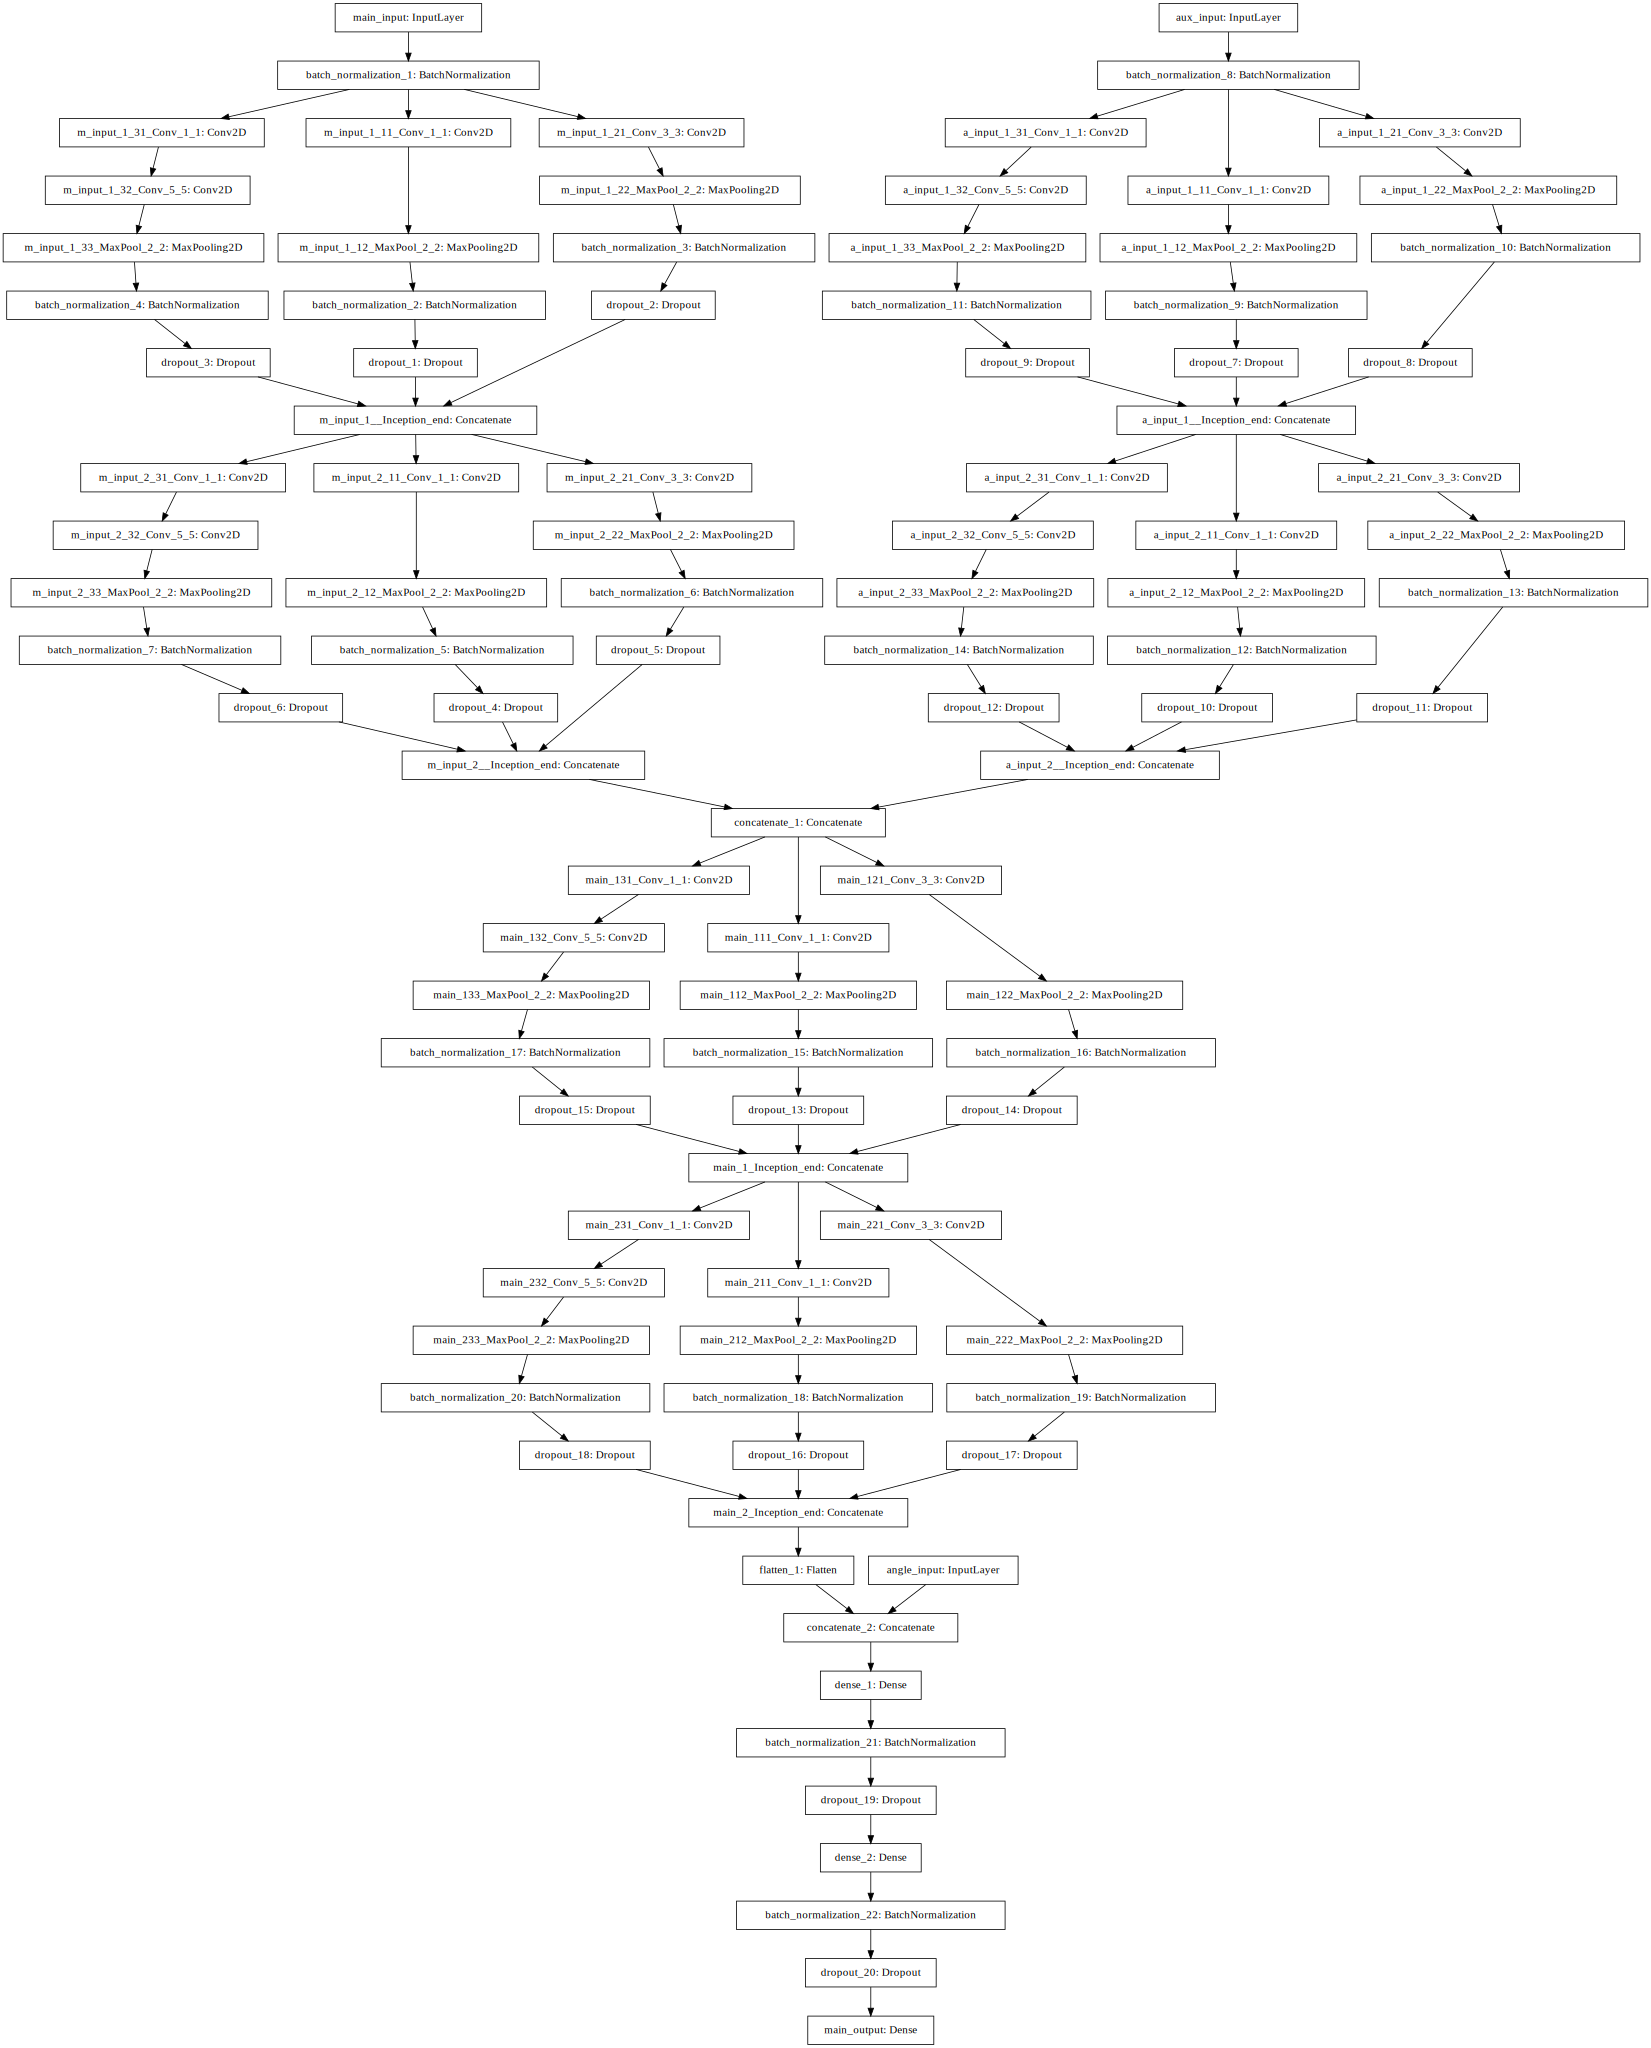

In [48]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
#import os
#os.environ["PATH"] += os.pathsep + 'd:/Anaconda3/Library/bin/graphviz/'
SVG(model_to_dot(model_f).create(prog='dot', format='svg'))

[>> back to TOC <<](#toc)

<a name="training-callbacks"/>
### Callbacks

In [49]:
# learning rate schedule
class LScheduler:
    def __init__(self, initial_lrate=0.001, drop=0.66, patience=5):
        self.initial_lrate=initial_lrate
        self.drop = drop
        self.patience = patience

    def step_decay(self,epoch):
        initial_lrate = self.initial_lrate
        drop = self.drop
        patience = self.patience
        lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/patience))
        if math.fmod(epoch, patience) == 0:
            print("Setting learning rate: ",lrate)
        return lrate

[>> back to TOC <<](#toc)

In [50]:
class ModelHistory(Callback):
    def __init__(self, listSize=10):
        self.listSize = listSize
        self.models = []

    def on_epoch_end(self, epoch, logs={}):
        lastLoss = logs.get('val_loss')
        rank = - lastLoss
        model_log = (rank, { 'val_loss':lastLoss,
                       'val_acc':logs.get('val_acc'),
                       'loss':logs.get('loss'),
                       'acc':logs.get('acc'),
                       'epoch': epoch,
                       'lr': K.get_value(self.model.optimizer.lr),
                       'weights':self.model.get_weights()
                     })
        if len(self.models) < self.listSize: #if the model heap is already full
            heapq.heappush(self.models, model_log)
        else:
            if rank > self.models[0][0]: # new model is better than the worst in the heap
                heapq.heappushpop(self.models, model_log)
            
    def head(self,n=5):
        tmp_dict = {
            'rank':[],
            'val_loss':[],
            'val_acc':[],
            'loss':[],
            'acc':[],
            'epoch':[],
            'lr':[]
        }
        for cnt,log in enumerate(heapq.nlargest(n,self.models)):    
            tmp_dict['rank'].append(log[0])
            tmp_dict['val_loss'].append(log[1]['val_loss'])
            tmp_dict['val_acc'].append(log[1]['val_acc'])
            tmp_dict['loss'].append(log[1]['loss'])
            tmp_dict['acc'].append(log[1]['acc'])
            tmp_dict['epoch'].append(log[1]['epoch'])
            tmp_dict['lr'].append(log[1]['lr'])
        return pd.DataFrame(tmp_dict)[['rank','val_loss','val_acc','loss','acc','lr']].head(n)

def get_callbacks(filepath, save_to_disc = True, lScheduler = None, 
                  step_decay=LScheduler().step_decay, modelHistoryCallback=None):
    
    msave = ModelCheckpoint(filepath, save_best_only=True)
    if lScheduler is None:
        lrScheduler = LearningRateScheduler(step_decay)
    else:
        lrScheduler = lScheduler
    tqdmCallback =  TQDMNotebookCallback(leave_inner=True, leave_outer=True)
    if (save_to_disc):
        return [msave, lrScheduler, modelHistoryCallback]
    else:
        return [lrScheduler, modelHistoryCallback]

[>> back to TOC <<](#toc)

<a name="model-training"/>
### Model Training

In [51]:
#name init
model_timestamp = str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S"))
model_best_weights_path = model_path + "weights." + model_code + "_" + model_timestamp + ".hdf5"
#lScheduler = LScheduler(initial_lrate=0.001, drop=0.66, patience=7)

In [52]:
#addtional training epochs - warm start
#lScheduler = LScheduler(initial_lrate=0.000001, drop=0.66, patience=3)
modelEnsemble = ModelHistory(listSize=33)
lScheduler = CyclicLR(base_lr=1e-7, max_lr=0.003,
                      step_size=9, mode='triangular4', 
                      beta=0.22, theta=0.22, gamma=0.66, step_patience=3)
callbacks = get_callbacks(filepath=model_best_weights_path, save_to_disc=False, lScheduler=lScheduler,
                          modelHistoryCallback=modelEnsemble)
model_f.compile(optimizer=Adam(lr=1e-3),loss='binary_crossentropy',metrics=['accuracy'])
start_time = time.monotonic()

H1 = model_f.fit_generator(datagen_angle.flow(X_train_sample, y_train_sample, batch_size=256, shuffle=True, 
                                             noise_on=True,noise=aug_noise),
                    steps_per_epoch=len(X_train_sample)/64,
                    validation_data=datagen_angle_val.flow(X_val_tune2, y_val_tune2, batch_size=48, shuffle=False, 
                                             noise_on=False,noise=aug_noise), 
                    validation_steps=len(X_val)/48,
                    #validation_data=[X_val,y_val],
                    epochs=75, callbacks=callbacks,
                    verbose=1)

model_time = time.monotonic() - start_time
print("Model training time: " + '{:d}'.format(int(model_time // 60)) + " minutes " 
      + '{:.1f}'.format(model_time % 60) + " seconds")

Epoch 1/1
87/86 [==============================] - 43s 491ms/step - loss: 0.7074 - acc: 0.4483 - val_loss: 9.0310 - val_acc: 0.4306
Model training time: 0 minutes 48.5 seconds


In [53]:
with open('models/modelEnsemble_volta_v29.pickle', 'wb') as handle:
    pickle.dump(modelEnsemble.models, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [54]:
print("Best models")
modelEnsemble.head(3)

Best models


,rank,val_loss,val_acc,loss,acc,lr
0,-9.030989,9.030989,0.430556,0.707441,0.448276,0.000154


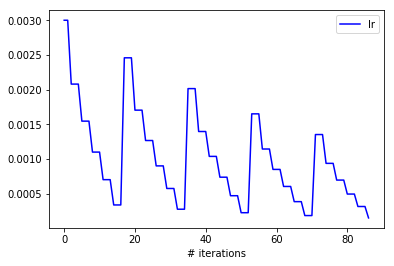

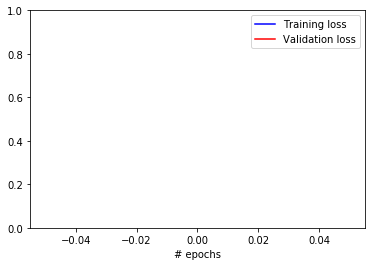

In [55]:
h = lScheduler.history
plt.plot(h['lr'], color="b", label='lr')
plt.legend()
plt.xlabel('# iterations')
plt.show()

plt.plot(H1.history['loss'], color="b", label='Training loss')
plt.plot(H1.history['val_loss'], color="r", label='Validation loss')
plt.legend()
plt.xlabel('# epochs')
plt.ylim(0,1)
plt.show()

In [ ]:
#heapq.nlargest(1,modelEnsemble.models)[0]

In [ ]:
model_f.set_weights(heapq.nlargest(1,modelEnsemble.models)[0][1]['weights'])

In [ ]:
# serialize model to JSON
model_json = model_f.to_json()
with open("models/model_volta_v29.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# load model from JSON - don't care about the weights rith now, they are saved separately
with open("models/model_volta_v29.json", "r") as json_file:
    loaded_model_json = json_file.read()
    model_f = model_from_json(loaded_model_json)

In [ ]:
#model_object_path = model_path + "model." + model_code + "_" + model_timestamp + '.hdf5'
#model_f.save('models/last_model.hdf5') //crashes python kernel with Keras version 2.1.2
#model_f = load_model(model_object_path)

In [ ]:
#for model_weights in modelEnsemble.models:
#    heapq.heappush(modelEnsemble.models, model_weights)

In [ ]:
with open('models/modelEnsemble_volta_v29.pickle', 'wb') as handle:
    pickle.dump(modelEnsemble.models, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
modelEnsemble = ModelHistory(listSize=106)
with open('models/modelEnsemble_volta_v29.pickle', 'rb') as handle:
    modelEnsemble.models = pickle.load(handle)

### Saving model history

In [ ]:
#argmin = np.array(H.history["loss"]).argmin()
#argmin

In [ ]:
#argmin = np.array(H.history["val_loss"]).argmin()
#argmax_acc = np.array(H.history["val_acc"]).argmax()
#with open('current_model.py','r') as model_python_code_file:
#    models_history = pd.DataFrame({"timestamp":[model_timestamp], 
#                                    "val_loss [min]":[H.history['val_loss'][argmin]],
#                                    "epoch [val_loss [min]]":argmin,
#                                    "training_loss [val_loss [min]]":[H.history['loss'][argmin]],
#                                    "val_acc [val_loss [min]]":[H.history['val_acc'][argmin]],
#                                    "training_acc [val_loss [min]]":[H.history['acc'][argmin]],
#                                    
#                                    "val_acc [max]":[H.history['val_acc'][argmax_acc]],
#                                    "epoch [val_acc [max]]":argmax_acc,
#                                    "training_loss [val_acc [max]]":[H.history['loss'][argmax_acc]],
#                                    "val_loss [val_acc [max]]":[H.history['val_loss'][argmax_acc]],
#                                    "training_acc [val_acc [max]]":[H.history['acc'][argmax_acc]],
#                                    
#                                    "model_path":[model_object_path],
#                                    "model_weights_path":[model_best_weights_path],
#                                    "model_python_code":[model_python_code_file.read().replace('\r\n','\n')],
#                                    "model_comment":[model_comment]
#                                })
#                               
#models_history = models_history[["timestamp", 
#                                 "epoch [val_loss [min]]", "val_loss [min]", "training_loss [val_loss [min]]",
#                                 "val_acc [val_loss [min]]", "training_acc [val_loss [min]]",
#                                 "epoch [val_acc [max]]", "val_acc [max]", "training_loss [val_acc [max]]",
#                                 "val_loss [val_acc [max]]", "training_acc [val_acc [max]]",
#                                 "model_path","model_weights_path","model_python_code","model_comment"]]
#models_history.head()

In [ ]:
#print("Min validation loss epoch:")
#print("epoch: %d" %(argmin),
#      "; val loss [min] %.4f: " % (models_history["val_loss [min]"][0]), 
#      "; training loss: %.4f" % (models_history["training_loss [val_loss [min]]"][0]),
#      "; val acc: %.4f" % (models_history["val_acc [val_loss [min]]"][0]),
#      "; training acc: %.4f " % (models_history["training_acc [val_loss [min]]"][0])
#     )
#print("Max validation accuracy epoch:")
#print("epoch: %d" %(argmax_acc),
#      "; val loss %.4f: " % (models_history["val_loss [val_acc [max]]"][0]), 
#      "; training loss: %.4f" % (models_history["training_loss [val_acc [max]]"][0]),
#      "; val acc [max]: %.4f" % (models_history["val_acc [max]"][0]),
#      "; training acc: %.4f " % (models_history["training_acc [val_acc [max]]"][0]),
#     )
#print("model comment:", model_comment)
#

In [ ]:
#with open('models_history.csv', 'a') as f:
#    models_history.to_csv(f, header=False,index=False)
#    #models_history.to_csv(f, index=False)

In [ ]:
#df = pd.read_csv('models_history.csv')
#df.tail()

### Model Ensemble

In [ ]:
heapq.nlargest(1,modelEnsemble.models)[0][1]['val_loss']

In [ ]:
model_f.set_weights(heapq.nlargest(1,modelEnsemble.models)[0][1]['weights'])
model_f.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0),
loss='binary_crossentropy',
metrics=['accuracy'])
model_f.evaluate_generator(datagen_angle_val.flow(X_val, y_val, batch_size=16, shuffle=False, 
                                             noise_on=False,noise=aug_noise), 
                           steps = len(X)/16)

In [ ]:
def get_prediction(model,weights, X, y):
    model.set_weights(weights)
    return model.predict_generator(datagen_angle_val.flow(X, y, batch_size=256, shuffle=False, 
                                             noise_on=False,noise=aug_noise), 
                           steps = len(X)/255, verbose=0)

In [ ]:
def get_ensemble_predictions(X, y, modelEnsemble):
    predictions = [get_prediction(model_f, model[1]['weights'], X, y)[:X.shape[0]]
                   for model in tqdm(modelEnsemble.models)]    
    temp_array = np.array(predictions)
    del(predictions)
    temp_array = np.swapaxes(temp_array,0,1)
    temp_array = temp_array.reshape(temp_array.shape[0],temp_array.shape[1])
    return temp_array

In [ ]:
#with h5py.File('tmp_data/ensemble_data.h5', 'r') as hf:
#    ensemble_train = hf['ensemble_train'][:]

In [ ]:
ensemble_val_tune = get_ensemble_predictions(X_val_tune2, y_val_tune2, modelEnsemble)
ensemble_val_test = get_ensemble_predictions(X_val_test2, y_val_test2, modelEnsemble)

In [ ]:
#ensemble_train = get_ensemble_predictions(np.append(X_train,X_val_tune2,axis=0), pd.concat([y_train,y_val_tune2]), modelEnsemble)

In [ ]:
y_train_val_tune2 = pd.concat([y_train,y_val_tune2])

In [ ]:
with h5py.File('tmp_data/ensemble_data.h5', 'w') as hf:
    hf.create_dataset("ensemble_val_tune",  data=ensemble_val_tune)
ensemble_val_tune.shape

In [ ]:
#with h5py.File('tmp_data/ensemble_data.h5', 'r') as hf:
#    ensemble_val = hf['ensemble_val'][:]

In [ ]:
ensemble_val_tune.shape

In [ ]:
y_val.shape

In [ ]:
with h5py.File('tmp_data/ensemble_data.h5', 'a') as hf:
    hf.create_dataset("ensemble_val_test",  data=ensemble_val_test)
ensemble_val_test.shape

In [ ]:
#with h5py.File('tmp_data/ensemble_data.h5', 'a') as hf:
#    hf.create_dataset("ensemble_val_train",  data=ensemble_val_train)
#ensemble_val.shape

In [ ]:
def modelfit(alg, X, y , X_test, y_test, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X, label=y)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='logloss', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X, y,eval_metric='logloss')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    dtrain_predprob = alg.predict_proba(X)[:,1]
    dtest_predprob = alg.predict_proba(X_test)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("n_estimators: %d" % cvresult.shape[0])
    print("Accuracy : %.4g" % metrics.accuracy_score(y, dtrain_predictions))
    print("Log loss (Train): %f" % metrics.log_loss(y, dtrain_predprob))
    print("Log loss (Test): %f" % metrics.log_loss(y_test, dtest_predprob))


In [ ]:
#ensemble_train = get_ensemble_predictions(X_train, y_train, modelEnsemble)
#with h5py.File('tmp_data/ensemble_data.h5', 'a') as hf:
#    hf.create_dataset("ensemble_train",  data=ensemble_train)

In [ ]:
#with h5py.File('tmp_data/ensemble_data.h5', 'r') as hf:
#    ensemble_train = hf['ensemble_train'][:]

In [ ]:
#ensemble_train.shape

In [ ]:
#ensemble_all = get_ensemble_predictions(X, y_angle, modelEnsemble)

### Fine tuning ensemble using xgboost

In [ ]:
params = {
    'lr':0.1,
    'n':35,
    'max_depth':5,
    'min_child_weight':1,
    'gamma':0,
    'subsample':0.8,
    'colsample_bytree':0.8,
}

In [ ]:
xgb1 = xgb.XGBClassifier(
 learning_rate = params['lr'],
 n_estimators = 1000,
 max_depth = params['max_depth'],
 min_child_weight = params['min_child_weight'],
 gamma = params['gamma'],
 subsample = params['subsample'], 
 colsample_bytree = params['colsample_bytree'],
 objective= 'binary:logistic',
 nthread=8,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, ensemble_val_tune, y_val_tune2['is_iceberg'], ensemble_val_test, y_val_test2['is_iceberg'])

In [ ]:
params = {
    'lr':0.1,
    'n':127,
    'max_depth':5,
    'min_child_weight':1,
    'gamma':0,
    'subsample':0.8,
    'colsample_bytree':0.8,
}

In [ ]:
param_test1 = {
 'max_depth':list(range(3,13,2)),
 'min_child_weight':list(range(1,10,2))
}
gsearch1 = GridSearchCV(
    estimator = xgb.XGBClassifier( 
         learning_rate=params['lr'], n_estimators=params['n'], max_depth=params['max_depth'],
         min_child_weight=params['min_child_weight'], gamma=params['gamma'], 
         subsample=params['subsample'], colsample_bytree=params['colsample_bytree'],
         objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=random_seed), 
param_grid = param_test1, scoring='neg_log_loss',n_jobs=1,iid=False, cv=5, verbose=1)
gsearch1.fit(ensemble_val_tune,y_val_tune2['is_iceberg'].values)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
gsearch1.best_params_

In [ ]:
params['max_depth'] = gsearch1.best_params_['max_depth']
params['min_child_weight'] = gsearch1.best_params_['min_child_weight']

In [ ]:
param_test2 = {
 'max_depth':[gsearch1.best_params_['max_depth']-1,gsearch1.best_params_['max_depth'],gsearch1.best_params_['max_depth']+1],
 'min_child_weight':[gsearch1.best_params_['min_child_weight']-0.5,
                     gsearch1.best_params_['min_child_weight'],
                     gsearch1.best_params_['min_child_weight']+0.5]
}
gsearch2 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=params['lr'], n_estimators=params['n'], 
                            max_depth=params['max_depth'],
                            min_child_weight=params['min_child_weight'], 
                            gamma=params['gamma'], subsample=params['subsample'], 
                            colsample_bytree=params['colsample_bytree'],
                            objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=random_seed), 
param_grid = param_test2, scoring='neg_log_loss',n_jobs=1,iid=False, cv=5, verbose=1)
gsearch2.fit(ensemble_val_tune,y_val_tune2['is_iceberg'].values)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

In [ ]:
params['max_depth'] = gsearch2.best_params_['max_depth']
params['min_child_weight'] = gsearch2.best_params_['min_child_weight']

In [ ]:
param_test3 = {
 'gamma':[i/20.0 for i in range(0,30)]
}
gsearch3 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=params['lr'], n_estimators=params['n'], 
                            max_depth=params['max_depth'], min_child_weight=params['min_child_weight'],
                            gamma=params['gamma'], subsample=params['subsample'], 
                            colsample_bytree=params['colsample_bytree'],
                            objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=random_seed), 
param_grid = param_test3, scoring='neg_log_loss',n_jobs=1,iid=False, cv=5, verbose=1)
gsearch3.fit(ensemble_val_tune,y_val_tune2['is_iceberg'].values)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

In [ ]:
params['gamma'] = gsearch3.best_params_['gamma']

In [ ]:
xgb2 = xgb.XGBClassifier(
 learning_rate=params['lr'],
 n_estimators=1000,
 max_depth=params['max_depth'],
 min_child_weight=params['min_child_weight'],
 gamma=params['gamma'],
 subsample=params['subsample'],
 colsample_bytree=params['colsample_bytree'],
 objective='binary:logistic',
 nthread=8,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, ensemble_val_tune, y_val_tune2['is_iceberg'],ensemble_val_test, y_val_test2['is_iceberg'])

In [ ]:
params['n'] = 73

In [ ]:
param_test4 = {
 'subsample':[i/10.0 for i in range(4,10)],
 'colsample_bytree':[i/10.0 for i in range(4,10)]
}
gsearch4 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=params['lr'], n_estimators=params['n'], 
                                max_depth=params['max_depth'], min_child_weight=params['min_child_weight'], 
                                gamma=params['gamma'], subsample=params['subsample'], 
                                colsample_bytree=params['colsample_bytree'],
                                objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=random_seed), 
param_grid = param_test4, scoring='neg_log_loss',n_jobs=1,iid=False, cv=5, verbose=1)
gsearch4.fit(ensemble_val_tune,y_val_tune2['is_iceberg'].values)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

In [ ]:
params['subsample'] = gsearch4.best_params_['subsample']
params['colsample_bytree'] = gsearch4.best_params_['colsample_bytree']

In [ ]:
param_test5 = {
 'subsample':[i/100.0 for i in range(int(gsearch4.best_params_['subsample']*100)-10,
                                     int(gsearch4.best_params_['subsample']*100)+10,5)],
 'colsample_bytree':[i/100.0 for i in range(int(gsearch4.best_params_['colsample_bytree']*100)-10,
                                            int(gsearch4.best_params_['colsample_bytree']*100)+10,5)]
}
gsearch5 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=params['lr'], n_estimators=params['n'], 
                                max_depth=params['max_depth'], min_child_weight=params['min_child_weight'], 
                                gamma=params['gamma'], subsample=params['subsample'], 
                                colsample_bytree=params['colsample_bytree'],
                                objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=random_seed), 
param_grid = param_test5, scoring='neg_log_loss',n_jobs=1,iid=False, cv=5, verbose=1)
gsearch5.fit(ensemble_val_tune,y_val_tune2['is_iceberg'].values)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

In [ ]:
params['subsample'] = gsearch5.best_params_['subsample']
params['colsample_bytree'] = gsearch5.best_params_['colsample_bytree']

In [ ]:
param_test6 = {
 'reg_alpha':[0, 1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 10]
}
gsearch6 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=params['lr'], n_estimators=params['n'], 
                                max_depth=params['max_depth'], min_child_weight=params['min_child_weight'], 
                                gamma=params['gamma'], subsample=params['subsample'], 
                                colsample_bytree=params['colsample_bytree'],
                                objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=random_seed),  
param_grid = param_test6, scoring='neg_log_loss',n_jobs=1,iid=False, cv=5, verbose=1)
gsearch6.fit(ensemble_val_tune,y_val_tune2['is_iceberg'].values)
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

In [ ]:
params['reg_alpha'] = gsearch6.best_params_['reg_alpha']

In [ ]:
xgb3 = xgb.XGBClassifier(
 learning_rate=params['lr'],
 n_estimators=1000,
 max_depth=params['max_depth'],
 min_child_weight=params['min_child_weight'],
 gamma=params['gamma'],
 subsample=params['subsample'],
 colsample_bytree=params['colsample_bytree'],
 objective='binary:logistic',
 nthread=8,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, ensemble_val_tune, y_val_tune2['is_iceberg'], ensemble_val_test, y_val_test2['is_iceberg'])

In [ ]:
xgb4 = xgb.XGBClassifier(
 learning_rate=0.01,
 n_estimators=1000,
 max_depth=params['max_depth'],
 min_child_weight=params['min_child_weight'],
 gamma=params['gamma'],
 subsample=params['subsample'],
 colsample_bytree=params['colsample_bytree'],
 objective='binary:logistic',
 nthread=8,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, ensemble_val_tune, y_val_tune2['is_iceberg'], ensemble_val_test, y_val_test2['is_iceberg'])

In [ ]:
with open('models/modelXgb4_volta_v29.pickle', 'wb') as handle:
    pickle.dump(xgb4, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('models/modelXgb4_volta_v29.pickle', 'rb') as handle:
    xgb5= pickle.load(handle)

### Predictions

In [ ]:
#use model
#model_object_path = "models\\model.CNN_2017_12_19_v15_2017_12_21_15_54_42.hdf5"
#model_best_weights_path = "models\\weights.CNN_2017_12_19_v15_2017_12_21_15_54_42.hdf5"

In [ ]:
#model_f = load_model(model_object_path)

In [ ]:
#model_f.load_weights(model_best_weights_path)

In [ ]:
#model_f.evaluate_generator(datagen_angle_val.flow(X_val, y_val, batch_size=32, shuffle=False), 
#                          steps = len(X_val)/32)

In [ ]:
test_df = pd.read_json("data/processed/test.json")

In [ ]:
test_df.head()

In [ ]:
test_df['inc_angle_f'] = pd.to_numeric(test_df['inc_angle'], errors='coerce')
print("missing values in inc_angle: ", test_df['inc_angle_f'].isnull().sum())
test_df['inc_angle_f'].replace(np.nan,0, inplace=True)
test_df.tail()

In [ ]:
_, _, _, _, _, X_test = get_bands(test_df)
y_angle_test = test_df.loc[:,['is_iceberg','inc_angle_f']]
y_angle_test['index'] = y_angle_test.index

In [ ]:
X_test.shape

In [ ]:
datagen_val.fit(X_test)
datagen_angle_val = Datagen_angle(imagegen=datagen_val)

In [ ]:
idx = 0
pred = get_prediction(model_f, modelEnsemble.models[idx][1]['weights'], X_test, y_angle_test)[:X_test.shape[0]]
pred = np.array(pred)
dataset_name = 'ensemble_data_%02d' % idx
with h5py.File('tmp_data/ensemble_test_data.hd5', 'w') as hf:
    hf.create_dataset(dataset_name,  data=pred)
idx=1
for i in tqdm(range(idx,idx+25), ascii=True):
    idx = i
    model = modelEnsemble.models[idx]
    pred = get_prediction(model_f, model[1]['weights'], X_test, y_angle_test)[:X_test.shape[0]]
    pred = np.array(pred)
    dataset_name = 'ensemble_data_%02d' % idx
    with h5py.File('tmp_data/ensemble_test_data.hd5', 'a') as hf:
        hf.create_dataset(dataset_name,  data=pred)

In [ ]:
idx2=32
with h5py.File('tmp_data/ensemble_test_data.hd5', 'r') as hf:
    ensemble_test = [hf['ensemble_data_%02d' % idx2][:]]

In [ ]:
idx+=1
for i in tqdm(range(idx,idx+25), ascii=True):
    idx = i
    model = modelEnsemble.models[idx]
    pred = get_prediction(model_f, model[1]['weights'], X_test, y_angle_test)[:X_test.shape[0]]
    pred = np.array(pred)
    dataset_name = 'ensemble_data_%02d' % idx
    with h5py.File('tmp_data/ensemble_test_data.hd5', 'a') as hf:
        hf.create_dataset(dataset_name,  data=pred)

In [ ]:
idx+=1
for i in tqdm(range(idx,idx+25), ascii=True):
    idx = i
    model = modelEnsemble.models[idx]
    pred = get_prediction(model_f, model[2], X_test, y_angle_test)[:X_test.shape[0]]
    pred = np.array(pred)
    dataset_name = 'ensemble_data_%02d' % idx
    with h5py.File('tmp_data/ensemble_test_data.hd5', 'a') as hf:
        hf.create_dataset(dataset_name,  data=pred)

In [ ]:
idx+=1
for i in tqdm(range(idx,idx+25), ascii=True):
    idx = i
    model = modelEnsemble.models[idx]
    pred = get_prediction(model_f, model[2], X_test, y_angle_test)[:X_test.shape[0]]
    pred = np.array(pred)
    dataset_name = 'ensemble_data_%02d' % idx
    with h5py.File('tmp_data/ensemble_test_data.hd5', 'a') as hf:
        hf.create_dataset(dataset_name,  data=pred)

In [ ]:
idx += 1
for i in tqdm(range(idx,len(modelEnsemble.models)), ascii=True):
    idx = i
    model = modelEnsemble.models[idx]
    pred = get_prediction(model_f, model[2], X_test, y_angle_test)[:X_test.shape[0]]
    pred = np.array(pred)
    dataset_name = 'ensemble_data_%02d' % idx
    with h5py.File('tmp_data/ensemble_test_data.hd5', 'a') as hf:
        hf.create_dataset(dataset_name,  data=pred)

In [ ]:
#ensemble_test = get_ensemble_predictions(X_test, y_angle_test, modelEnsemble)
#with h5py.File('tmp_data/ensemble_data.h5', 'a') as hf:
#    hf.create_dataset("ensemble_test",  data=ensemble_train)

In [ ]:
#n = len(modelEnsemble.models)
n = 33
with h5py.File('tmp_data/ensemble_test_data.hd5', 'r') as hf:
    ensemble_test_list = [hf['ensemble_data_%02d' % idx2][:] for idx2 in tqdm(range(0,n), ascii=True)]

In [ ]:
ensemble_test = np.array(ensemble_test_list)
ensemble_test = np.swapaxes(ensemble_test,0,1)
ensemble_test = ensemble_test.reshape(ensemble_test.shape[0],ensemble_test.shape[1])
ensemble_test.shape

In [ ]:
with open('models/modelXgb4_volta_v29.pickle', 'rb') as handle:
    xgb4 = pickle.load(handle)

In [ ]:
test_probs = xgb4.predict_proba(ensemble_test)
predictions = test_probs

In [ ]:
predictions[:,1]

In [ ]:
submission = pd.DataFrame({'id': test_df['id'], 'is_iceberg': predictions[:,1]})
submission.head(10)
submission.to_csv("submission.ensemble.xgboost.106.v29.csv", index=False)